In [2]:
%matplotlib inline
from sentiment import df_sentiment
from candidates_class import df_candidates
from Politweet import get_tweets
import datetime
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")
sns.set_context("notebook")

In [4]:
tweets = get_tweets('./datasets/tweets.tsv')
tweets, sent_pipeline = df_sentiment(tweets)
tweets, cand_pipeline = df_candidates(tweets)

tweets['time'] = tweets['pub.date.GMT'].apply(
    lambda x: ( datetime.datetime.strptime( x, "%m/%d/%y %H:%M" ))
)

# tweets[['pub.']].to_csv('./worked.csv')
tweets[['pub.date.GMT', 'sent_tfidf', 'candidate']].to_csv('./worked.csv')

# Through time

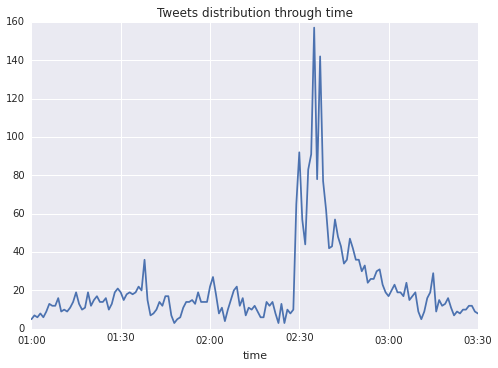

In [5]:
df = tweets.groupby(['time']).size().plot(title="Tweets distribution through time")


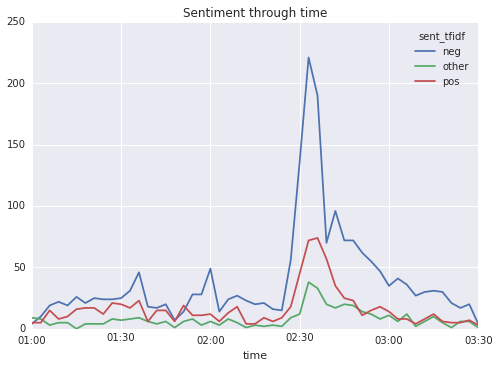

In [6]:
df = tweets.groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).sum().plot(title="Sentiment through time")

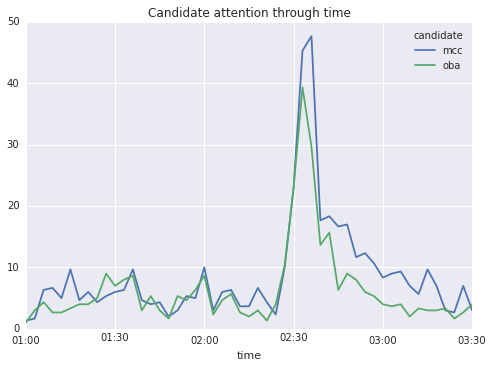

In [7]:
df = tweets[tweets["candidate"].str.contains('oba|mcc')].groupby(['time','candidate']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Candidate attention through time")

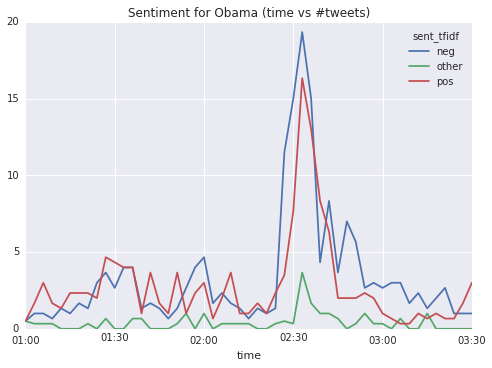

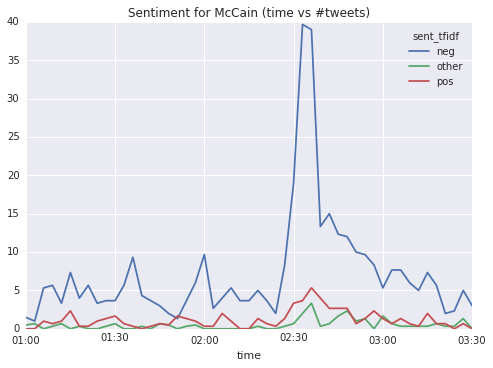

In [8]:
df = tweets[tweets["candidate"] == 'oba'].groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for Obama (time vs #tweets)")

df = tweets[tweets["candidate"] == 'mcc'].groupby(['time','sent_tfidf']).size().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for McCain (time vs #tweets)")

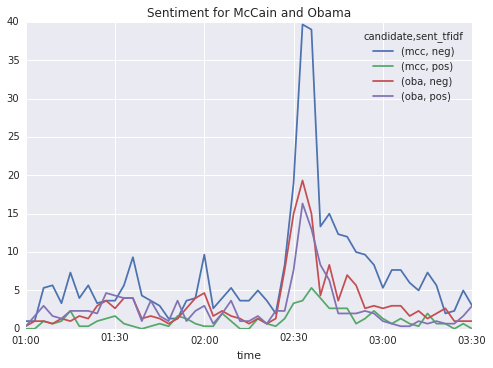

In [9]:
df = tweets[(tweets["candidate"].str.contains('oba|mcc')) & (tweets['sent_tfidf'] !='other')].groupby(['time','sent_tfidf', 'candidate']).size().unstack().unstack().fillna(0)
df.groupby(pd.TimeGrouper('3Min')).mean().plot(title="Sentiment for McCain and Obama")

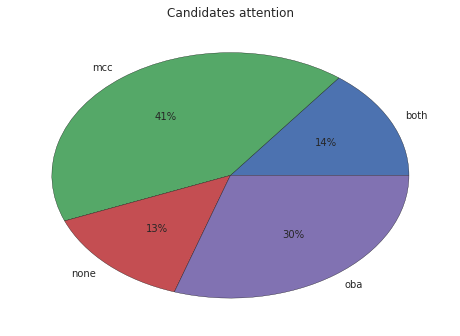

In [10]:
tweets.groupby(['candidate']).size().plot(kind='pie', autopct='%i%%', title="Candidates attention")

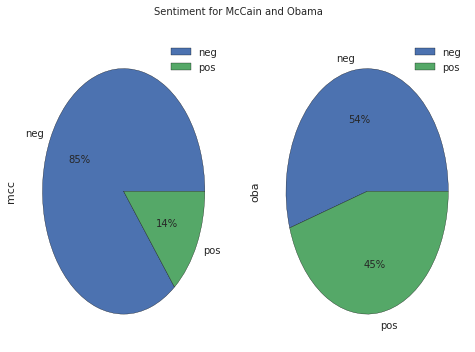

In [11]:
df = tweets[(tweets["candidate"].str.contains('oba|mcc')) & (tweets['sent_tfidf'] !='other')].groupby(['sent_tfidf', 'candidate']).size().unstack().fillna(0).plot(title="Sentiment for McCain and Obama", autopct='%i%%', kind="pie", subplots="True")

In [12]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

def featurize(tweet):
    tokens = [token['lemma'] for token in tweet['clean']]
    return tokens

def run_classifier(train, test, vctrzr, clsfr):
    X_train = vctrzr.fit_transform([i[0] for i in train])
    X_test = vctrzr.transform([i[0] for i in test])
    clsfr.fit(X_train, [i[1] for i in train])
    scr = clsfr.score(X_test, [i[1] for i in test])
    imp_features = sorted(zip(clsfr.coef_[0], vctrzr.get_feature_names()))
    return scr, imp_features

vectorizer = TfidfVectorizer(tokenizer = featurize, lowercase=False)
classifier = LinearSVC()

In [13]:
from sentiment import prepare_sentiment_data
from candidates_class import prepare_candidate_data
train, test = prepare_sentiment_data(tweets)
score, imp_features = run_classifier(train, test, vectorizer, classifier)

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

show_most_informative_features(vectorizer, classifier)

	-1.6875	good           		2.1633	mccain         
	-1.4320	presidential   		1.7443	nt             
	-1.3778	obama          		1.6787	stop           
	-1.1599	2              		1.4051	re             
	-1.1302	win            		1.3687	bracelet       
	-1.1123	tax            		1.3347	threat         
	-1.0985	comment        		1.2661	every          
	-1.0740	twitter        		1.1790	republican     
	-1.0225	tweetdebate    		1.0838	lose           
	-1.0093	victory        		1.0808	guess          
	-0.9867	leave          		1.0590	much           
	-0.9624	clearly        		1.0077	bad            
	-0.9622	rock           		1.0012	miss           
	-0.9615	hold           		0.9952	liar           
	-0.9560	clear          		0.9869	big            
	-0.9529	great          		0.9641	momocrats      
	-0.9507	glad           		0.9431	hate           
	-0.9492	agree          		0.9372	sigh           
	-0.9395	see            		0.9305	usa            
	-0.9326	top            		0.9264	must           


In [14]:
len(tweets)

3238